## Introduction

This blog post serves as a review and a showcase of the various statistical inference and modelling techniques utilised by the WDSS Machine Learning Competition Team over the Autumn and Winter seasons in 2021.

Throughout the post, each technique is explained in chronological order to accurately portray the thought process of the team tackling the problem.

The purpose of this report is to potentially inspire readers to participate in data science competitions or even take an interest in data science if they have not already.

## Preliminaries

Before explaining the team's problem solving process, the problem itself must be formulated.

### The Competition

The competition we entered was the "Store Sales - Time Series Forecasting" competition on Kaggle. The objective was to create 15 day forecasts for the sales figures of 33 different products for 54 stores belonging to the same retailer.

In summary, we had to make accurate 15 day predictions for 1782 individual time series using data scientific methods.

### The Data

Before proceeding with creating the predictions, it was essential to examine the information, in the form of tabular data sets, given to us and determine the utility of each set.

The training data set contained past sales data, product families and if the products were on promotion. The rest of the datasets contained additional exogenous variables:
- Oil prices 
- The location, type and the daily number of transactions for each store
- Ecuadorian holidays

### The Methodology

As with any data scientific project, we all carried out an EDA (Exploratory Data Analysis) to determine how to use the data for modelling.

The following is brief list of what modelling and inference techniques we used for this competition:
- Metrics for comparing time series;
    - Euclidean distance
    - Dynamic time warping
- Methods of clustering time series;
    - UMAP-assisted K-means clustering
- Time series modelling methods;
    - SARIMAX model
    - State-space model
    - LSTM model

In the following sections, we give a detailed overview of:
- Our EDA and thought process
- The decisions we made regarding how we use the data and their justifications
- The underlying theory and code for our methods

### Aggregate Correlation of Sales

We will investigate whether all sales time series for a given product family are similar enough to be treated identically.

A simple 'measure' for the similarity between two time series is the linear correlation coefficient between the values of both series. Letting $a_i$ be the $i$ th value in the first time series and $b_i$ be the $i$ th value in the second series, plot the coordinates $(a_i, b_i)$ for all $i$. If a linear relationship is clearly visible, then both time series are approximately similar.

Two time series are completely similar if they are both affine tranformations of each other (i.e. it is possible to express time series $a_i$ in terms of $b_i$ as $A + B a_i$, where $A$ and $B$ are real values).

It is costly to compare a large number of time series with each other to produce a correlation matrix, especially when the time series contain more than 1.5 thousand values. A less reliable, but quicker solution is to compare each time series with the sum of all time series (the aggregate time series).

The aggregate time series would be approximately similar to every series that forms the largest similarity group. This way, one can detect the existence of series groupings with a given set of series.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(style='whitegrid', rc={'grid.color': '.9', 'axes.edgecolor': '.4'})  # set seaborn style

from scipy.spatial import distance
import scipy.stats
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from IPython.display import display

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log
import datetime

# Ivan's separate file
import custompack

In [3]:
stores_raw = pd.read_csv(r'store-sales-time-series-forecasting-data/stores.csv')
stores = stores_raw[['store_nbr', 'city', 'state']]

df_raw = pd.read_csv(r'store-sales-time-series-forecasting-data/train.csv')

dataframe_train = df_raw
dataframe_oil = pd.read_csv(r'store-sales-time-series-forecasting-data/oil.csv',)
dataframe_test = pd.read_csv(filepath_or_buffer = 'store-sales-time-series-forecasting-data/test.csv')

# 'dataframe_transactions' is transactions data set
dataframe_transactions = pd.read_csv(
    filepath_or_buffer = 'store-sales-time-series-forecasting-data/transactions.csv'
    )

dataframe_full = pd.concat(
    objs = [
        dataframe_train,
        dataframe_test,
    ], sort = True,
)


# Create 'datetime_start_date' as the starting date
datetime_start_date = datetime.datetime(
    year = 2013,
    month = 1,
    day = 1,
)

# Create 'datetime_end_date' as the final date
datetime_end_date = datetime.datetime(
    year = 2017,
    month = 8,
    day = 31,
)

# Create 'datetimeindex_fulldate', the list of all
# dates from the initial to the final date
datetimeindex_fulldate = pd.date_range(
    start = datetime_start_date,
    end = datetime_end_date,
)

# Convert 'datetimeindex_fulldate' into a pandas
# dataframe
dataframe_fulldate = pd.DataFrame(data = {'date': datetimeindex_fulldate})

dataframe_oil['date'] = pd.to_datetime(
    arg = dataframe_oil[
        'date' # No comma here
    ],
)

dataframe_oil_mod_1 = pd.merge(
    left = dataframe_oil,
    right = dataframe_fulldate,
    how = 'right',
    on = 'date',
).sort_values(by = 'date')

# Reset the index of 'dataframe_oil_mod_2' to get
# 'dataframe_oil_mod_3', fill all missing values, backfill any remaining missing values
dataframe_oil_mod_f = custompack.index_reset(
    dataframe = dataframe_oil_mod_1,
).ffill().bfill()

def time_series_retrieval(store_number, family):
    
    '''
    The 'time_series_retrieval' function retrieves
    the sales and promotion time series for a given
    store number and product family.
    '''

    # Filter 'dataframe_full' by the input store
    # number and family to get 'dataframe_x_1'
    dataframe_x_1 = dataframe_full[
        (
            dataframe_full[
                'store_nbr' # No comma here
            ] == store_number
        ) & (
            dataframe_full[
                'family' # No comma here
            ] == family
        )
    ]
    
    # Reset the index of 'dataframe_x_1' to
    # get 'dataframe_x_2'
    dataframe_x_2 = custompack.index_reset(
        dataframe = dataframe_x_1,
        )

    # Drop the 'store_nbr' and 'family' features
    # from 'dataframe_x_2' to get 'datafarme_x_3'
    dataframe_x_3 = dataframe_x_2.drop(
        labels = [
            'store_nbr',
            'family',
        ],
        axis = 1,
    )

    # Convert the 'date' feature in 'dataframe_x_3'
    # to be of a 'datetime' data type
    dataframe_x_3['date'] = pd.to_datetime(
        arg = dataframe_x_3[
            'date' # No comma here
        ],
    )
    
    # Merge 'dataframe_fulldate' with the 'date' feature of
    # 'dataframe_x_3' to get 'dataframe_x_4'
    dataframe_x_4 = dataframe_x_3.merge(
        right = dataframe_fulldate,
        how = 'right',
        on = 'date',
    )
    
    # Sort the observations in 'dataframe_x_4' 
    # by increasing 'date' to get 'dataframe_x_5'
    dataframe_x_5 = dataframe_x_4.sort_values(
        by = 'date', 
        ascending = True,
    )

    # Fill missing values of 'dataframe_x_5' with 
    # zeros to get 'dataframe_x_6'
    dataframe_x_6 = dataframe_x_5.fillna(
        value = 0,
    )

    # Reset the index of 'dataframe_x_6' to get
    # 'dataframe_x_f'
    dataframe_x_f = custompack.index_reset(
        dataframe = dataframe_x_6,
    )

    return(
        dataframe_x_f # No comma here to avoid tuples
    )


dataframe_subject_1 = time_series_retrieval(
    store_number = 20,
    family = 'EGGS'
)


dataframe_subject_f = pd.merge(
    left = dataframe_subject_1,
    right = dataframe_oil_mod_f,
    how = 'outer',
    on = 'date' 
)

series_date = dataframe_subject_f['date']
series_sales = dataframe_subject_f['sales']
series_oil = dataframe_subject_f['dcoilwtico']
series_promo = dataframe_subject_f['onpromotion']

In [4]:
str_family = 'BEAUTY'

def short_sales_series(store_number, family):

    dataframe_series = time_series_retrieval(
        store_number = store_number,
        family = family
    )

    series_sales = dataframe_series[
        'sales'
    ]

    series_sales_short = custompack.series_extender(
        series_main = series_sales,
        int_extension = - 16
    )

    return(
        series_sales_short
    )


# Create 'series_sum', the series on to which
# all sales will be added to
series_sum = pd.Series(
    data = np.zeros(
        shape = 1688,
    )
)

for int_i in range(1, 55):
    series_sum += short_sales_series(
        store_number = int_i, 
        family = str_family
    )


# Normalise 'series_sum'
series_sum_norm = (series_sum - np.mean(series_sum)) / (np.std(series_sum))
# Create list for storing correlation coefficients
list_correlation = list()

for int_i in range(1, 55):

    list_correlation.append(
        scipy.stats.pearsonr(
            x = series_sum_norm,
            y = short_sales_series(
                store_number = int_i, 
                family = str_family
            )
        )[0]
    )

# Filter out any missing values arising from
# invalid correlation calculations
list_correlation_mod = [
    float_x for 
    float_x in 
    list_correlation if 
    np.isnan(float_x) == False
]

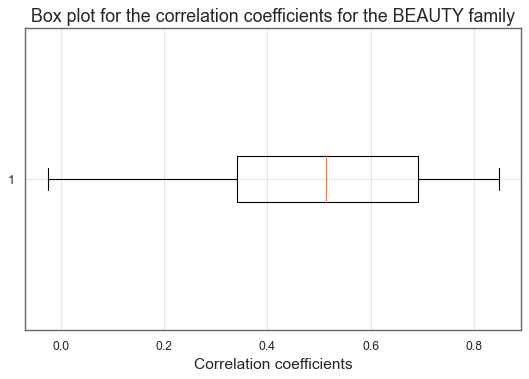

In [5]:
# Visualise the distribution of 'list_correlation'
plt.figure(num = 0, figsize = (8, 5), dpi = 80)
plt.title(label = 'Box plot for the correlation coefficients for the ' + 
    str_family + ' family', size = 16)
plt.xlabel(xlabel = 'Correlation coefficients', size = 14)
plt.boxplot(x = list_correlation_mod, vert = False)
plt.show()

This EDA showed that the degree of similarity between series from the same product family can vary drastically. For example, for the BEAUTY family, it ranged from small negative values to 0.85 with a mean of 0.5. Hence, there is convincing evidence that the time series can't be trivally grouped by the product family they represent.

## Clustering

By grouping similar time series data together, we may be able to reduce the number of models to fit. We focus on grouping stores and product types.

The clustering technique we use is UMAP-assisted k-Means clustering. We focus on two notions of distance: dynamic time warping and Euclidean distance. There is a reliability-speed trade-off among these two distances, as we explain below.

## The notion of distance for clustering

We need to standardize our data, such that comparisons are fair. Naturally, more expensive products may fluctuate more, but the underlying structure may be similar to cheaper products, and we want to be be able to make such comparison.

#### Dynamic time warping
We can choose dynamic time warping (DTW) or Euclidean distance for our clustering. DTW is a reliable algorithm for measuring similarity between two temporal sequences. It is able to match peaks to peaks, troughs to troughs, and account for any stretching, shrinking, and shifting/phase difference. This is helpful, since two 'close' time series can exhibit slight differences as described. 

A drawback of dynamic time warping is that it is computationally intensive by design. If we use it for clustering on a large dataset, which we have, we are doing a lot of expensive computations. This limits the usefulness of DTW, which could be remedied for example with cloud computing. 

#### Euclidean distance
Euclidean distance is fast, as naive comparison of two time series vertically is a simple computation. When two time series only differ in magnitude but match in phase, Euclidean distance is good enough.

However, Euclidean distance is not as reliable as DTW. Imagine two time series that look like sin curves, but one is shifted out of phase. Intuitively, these time series are very similar, and should be grouped together. A vertical point-to-point comparison by Euclidean distance gives us a large distance. As a result, distances between two time series may be erroneously larger than it actually is.

Due to computational constraints, we will be proceeding with euclidean distance.

# UMAP
We choose the smallest number of clusters that capture at least 97% of the distortions. In this case, 5 clusters.

In [6]:
df = df_raw.drop('id', axis=1)
df['date'] = df['date'].astype('datetime64[ns]')
df = df.sort_values(by=['date'], axis=0)

df = df.pivot(index='date', columns=['family','store_nbr'], 
                               values=['sales']).transpose()

df[:] = pd.DataFrame(StandardScaler().fit_transform(df.transpose())).transpose()

index_labs = df.index.to_frame()[['family','store_nbr']].reset_index(drop=True)

index_labs = pd.merge(
    index_labs, 
    stores,
    on='store_nbr'
)

In [ ]:
umap_3d = UMAP(n_components=3, n_neighbors=15, metric='euclidean' , init='random', random_state=0)

proj_3d = umap_3d.fit_transform(df.to_numpy())

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(proj_3d)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=clusters.astype('str'),
    labels={'color': 'Cluster'}, 
)
fig_3d.update_traces(marker_size=5)
fig_3d.update_layout(scene = dict(
                    xaxis_title='Component 1',
                    yaxis_title='Component 2',
                    zaxis_title='Component 3'))                   

In [11]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'Kaasiak'
api_key = 'wPJV4O2WS9woxmWNr0dw'

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
url = py.plot(fig_3d, filename = 'sales-forecasting-clusters', auto_open=False)
iframe  = tls.get_embed(url)

print((iframe.strip('')))

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~Kaasiak/1.embed" height="525" width="100%"></iframe>


<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~Kaasiak/1.embed" height="525" width="100%"></iframe>

## Cluster Analysis

### Heatmaps
By looking at clustermaps, we can see how similarly each cluster behaves.

We analysed clusters from a number of perspectives: the percentage of cluster members belonging to each family, state, city and store number. We concluded that it is only the product's family accounts for a reasonable amount of difference and that is not the case for other characteristics. However, aggregate correlation showed that even the similarities within product families are limited. Therefore, we will be proceeding with fitting separate models for each family in each stores.

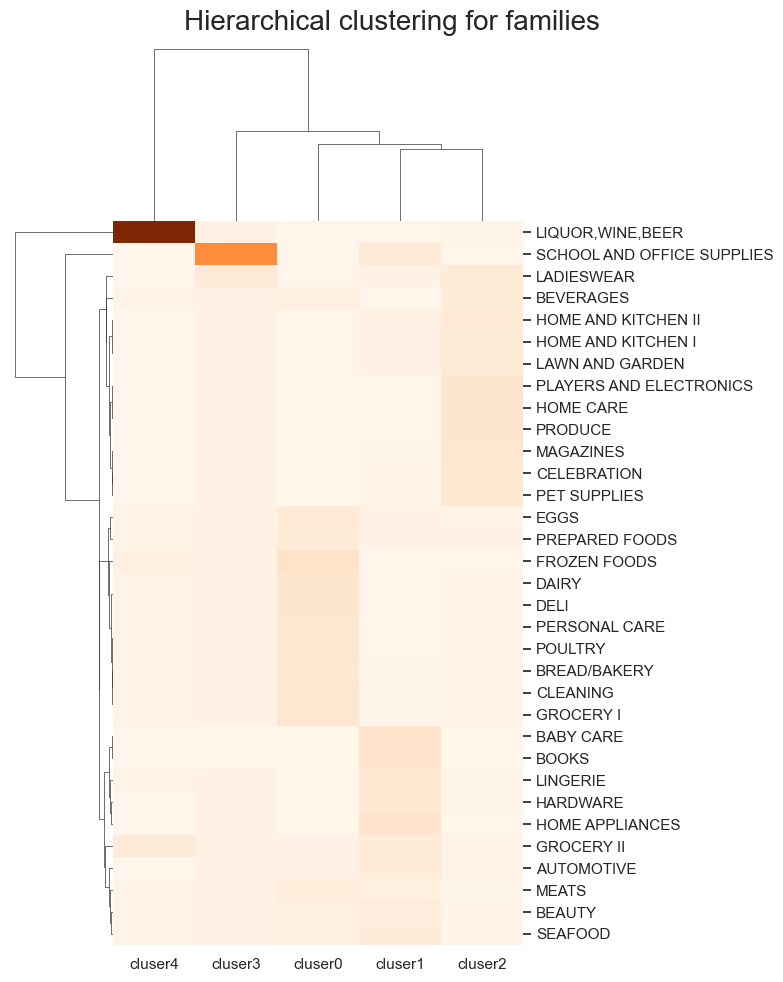

In [42]:
c_set = pd.DataFrame(data={'cluster_number': clusters})

def display_cluster_info(num):
    
    globals()['cluster'+str(num)+'indexes'] = c_set[c_set['cluster_number'] == num].index.tolist()
    globals()['cluster'+str(num)+'rows'] = df.iloc[globals()['cluster'+str(num)+'indexes']]
    
    # Analysis of store_nbr, city, state, and family

    ############################################################

    # store_nbr 
    a = globals()['cluster'+str(num)+'rows'].reset_index()['store_nbr'].value_counts(normalize=True)\
    .sort_values(ascending=False)

    # city 
    b = pd.merge(
        globals()['cluster'+str(num)+'rows'].reset_index(), 
        stores,
        on='store_nbr'
    )['city'].value_counts(normalize=True).sort_values(ascending=False)

    # state 
    c = pd.merge(
        globals()['cluster'+str(num)+'rows'].reset_index(), 
        stores,
        on='store_nbr'
    )['state'].value_counts(normalize=True).sort_values(ascending=False)

    # family
    d = globals()['cluster'+str(num)+'rows'].reset_index()['family'].value_counts(normalize=True)\
    .sort_values(ascending=False)
    
    
    globals()['cluster'+str(num)+'store_nbr'] = a
    globals()['cluster'+str(num)+'city'] = b
    globals()['cluster'+str(num)+'state'] = c
    globals()['cluster'+str(num)+'family'] = d
    
    
    ############################################################
    
    # display
      
    analysis_list = [a, b, c, d]
    
for i in range(clusters.max()+1):
    display_cluster_info(i)
    
CB_family = pd.DataFrame(
        {
            'cluser0' : cluster0family ,
            'cluser1' : cluster1family ,
            'cluser2' : cluster2family ,
            'cluser3' : cluster3family ,
            'cluser4' : cluster4family ,
        }
    ).fillna(0)


g = sns.clustermap(CB_family,cmap="Oranges",  cbar_pos=None, figsize = (8, 10))
g.fig.suptitle('Hierarchical clustering for families', size = 20) 
g.fig.subplots_adjust(top=.95)
g.fig.set_dpi(100)

# ARIMA

In this section, we go through fitting an ARIMA model on a time series for one of the families of products in one store; to see how well it performs. 

We are now going to create a dataset for the sales of <b> Bread/Bakery </b> in <b> store 44 </b>.

In [43]:
train = df_raw
df = train.loc[(train.store_nbr == 44) & (train.family == 'BREAD/BAKERY')]

One very important assumption of an ARIMA model is for the data to be stationary. We will test this with a hypothesis test called ADF (Augmented Dickey-Fuller).

<b> NOTE: </b> The null hypothesis of the ADF test is that the time series is non-stationary. 

We have a p value of 0.214832, So we do not reject the null hypothesis and so the series is non-stationary. In order to still be able to use ARIMA, we are going to difference our data.

Let us now plot the original timeseries, as well as the 1st and 2nd order differenced time series with their ACF (Autocorrelation) plots to determine the order of differencing we are going to use in our model:

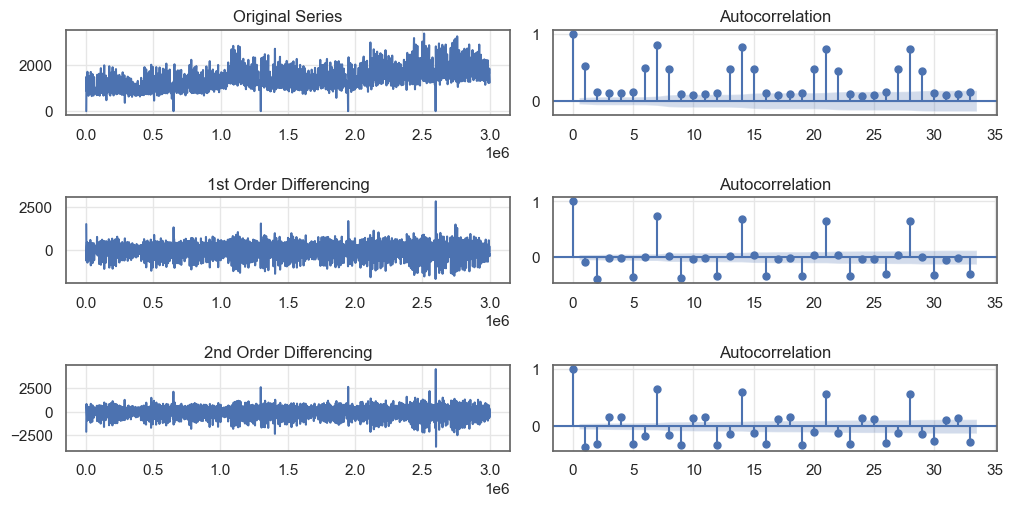

In [46]:
plt.rcParams.update({'figure.dpi':120})

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (10, 5), dpi = 100)

ax[0, 0].plot(df.sales); ax[0, 0].set_title('Original Series')
plot_acf(df.sales, ax=ax[0, 1])

ax[1, 0].plot(df.sales.diff()); ax[1, 0].set_title('1st Order Differencing')
plot_acf(df.sales.diff().dropna(), ax=ax[1, 1])

ax[2, 0].plot(df.sales.diff().diff()); ax[2, 0].set_title('2nd Order Differencing')
plot_acf(df.sales.diff().diff().dropna(), ax=ax[2, 1])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

The p-value for the first order differenced data is close to 0, so we can proceed with using this transformation. We now move on to identifying the number of AR terms (p) and the number of MA terms (q) that we are going to include in our ARIMA model. We do this by inspecting the ACF and PACF plots for the data.

We use q = 2 based on the autocorrelation plot and p = 6 based on the partial autocorrelation plot to fit the ARIMA model. The residuals seem to exhibit no significant patterns. We can now predict the sales for the 16 last observations from the original dataset that we kept as a test set. The predictions seem to align well with the actual data.

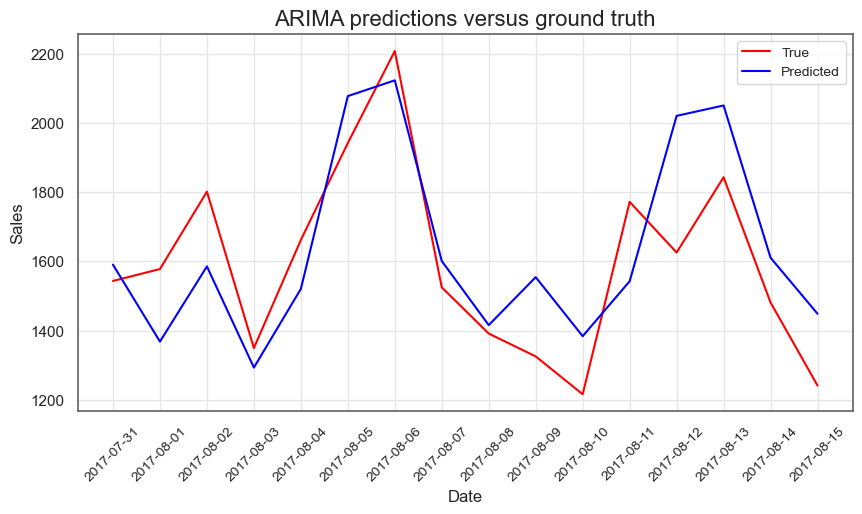

In [55]:
from warnings import filterwarnings
filterwarnings('ignore')

split_point = df.shape[0] - 16
df_train = df.iloc[:split_point, :]
df_test = df.iloc[split_point:, :]
df_train.reset_index(inplace=True)

import statsmodels.api as sm
# 6,1,2 ARIMA Model
model = sm.tsa.arima.ARIMA(df_train.sales, order=(6,1,2)) #p,d,q
model_fit = model.fit()

plt.rcParams.update({'figure.figsize':(10, 5), 'figure.dpi':100})
plt.plot(df_test.date, df_test.sales, c='red', label='True')
plt.plot(df_test.date, model_fit.forecast(steps=16), c='blue', label='Predicted')
plt.legend(prop={'size':10})
plt.title("ARIMA predictions versus ground truth", size = 16)
plt.xticks(fontsize=10, rotation = 45)
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

## SARIMA

Seasonality definitely plays a role in the time series of some of the families of products in some of the stores, so using a seasonal ARIMA (SARIMA) could be a further improvement.

We fit a SARIMA model to explore any weekly trends and we automated the process of selecting the model's parameters. However, using a grid search for selecting the best SARIMA parameters based on root-mean-square error is computationally expensive. Applying it to thousands of families of products would take a significant amount of time. Hence, we decided to explore other models with fewer parameters to specify.

## Dynamic Linear Models

State space models are a generalisation of general linear regression models. Unlike GLMs, which include ARIMA models, SSMs can consider cases where the underlying distribution of the parameters of the model changes over time. A dynamic linear model is an SSM that assumes the data can be modelled as a linear combination of its parameters.

### DLM Theory

A standard DLM can be formulated by the following four equations, given we already have data up until time $t-1$:

<center>

$x_t = \phi_t \cdot b_t + \epsilon_t : \epsilon_t \sim N(0, v_t)$

$b_t = F_t \cdot b_{t-1} + \Delta_t : \Delta_t \sim N(0, v_{t-1} \Sigma_t)$

$b_{t-1} = m_{t-1} + B_{t-1} : B_{t-1} \sim N(0, v_{t-1} B_{t-1})$

$v_t = \delta v_{t-1}$
    
</center>

The first equation is an ordinary linearity assumption for the data, the same one for ordinary linear regression, except the parameters can vary over time.

The second equation is the hidden model and is the key assumption for a linear model to be dynamic.

The third equation is a reiteration of the fact that the model parameters are random as well. The parameters possess an initial prior distribution which updates as more data is collected.

The fourth equation models the change in variance as time progresses.

Each term at time $t$ is defined as follows:
- $x_t$ is the data
- $b_t$ is the parameter vector
- $\epsilon_t$ is a normally distributed variable with variance $v_t$

- $m_t$ is the expectation of the parameters
- Both $B_{t}$ and $\Delta_t$ are multivariate normally distributed vectors with covariance matricies $v_t B_t$ and $v_{t-1} \Sigma_t$ respectively

- $\phi_t$ and $F_t$ are the transition vector and matrix respectively, which define how the model parameters combine linearly
- $\delta$ is the discount factor, a value in the interval of zero to one that models the increasing uncertainty in the distribution of future data

The model reduces to ordinary linear regression if:
- $F_t$ is the identity matrix for all $t$
- $\Sigma_t$ is the zero matrix for all $t$
- $\delta$ is one, so there is no increasing uncertainty in the distribution of future data

The dynamic linear model offers a high degree of modelling flexibility, as well as offering a convenient method for updating the model parameters over time.

In [56]:
int_series_cut = 16
int_series_pred = 16

# Set 'series_nds', the series containing
# all one-step forecasts and the predictions
# for the sales generated by the DLM defined
# below
series_nds = custompack.filter_arma(
    series_x = series_sales,
    tuple_hyperpar = (
        np.array([series_sales[0]]),
        np.array([[0.5]]),
        np.array([[1]]),
        np.array([[0.9]]),
    ),
    vector_phi = np.array([1]),
    series_y = pd.Series([]),
    series_z = pd.Series([]),
    float_delta = 1,
    int_ar_terms = 50,
    int_series_cut = int_series_cut,
    int_series_pred = int_series_pred,
)

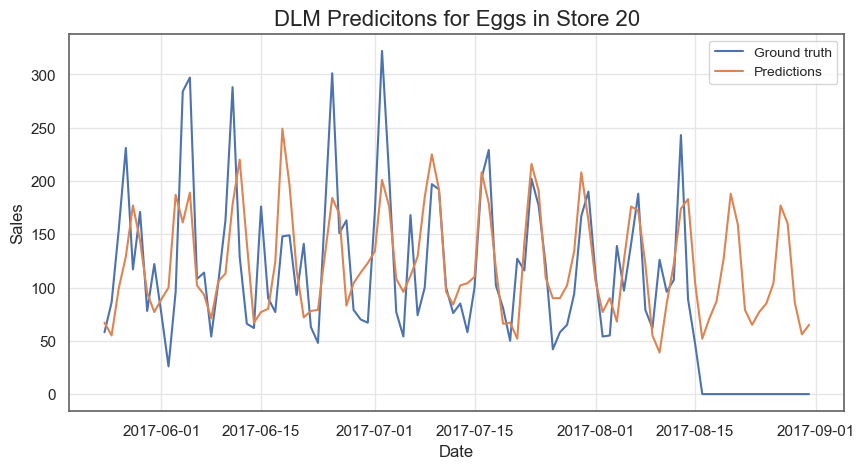

In [60]:
series_fulldate = pd.Series(
    data = datetimeindex_fulldate,
)

int_date_length = len(series_fulldate)

int_farback = 0
int_inter = 100

int_start = int_date_length - int_inter - int_farback
int_end = int_date_length - int_farback

series_extended_sales = custompack.series_extender(
    series_main = series_sales,
    int_extension = int_series_pred - int_series_cut,
)

plt.figure(
    num = 0,
    figsize = (10, 5)
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_sales.iloc[int_start: int_end],
    label="Ground truth"
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_nds.iloc[int_start: int_end],
    label='Predictions'
)
plt.legend(fontsize=10)
plt.title("DLM Predicitons for Eggs in Store 20", size = 16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## LSTM

Long short-term memory (LSTM) is a recurrent neural network (RNN) that utilises two different hidden variables rather than one to learn about the behaviour of a sequential process. In theory, LSTMs could capture deeper non-linear underlying patterns in the data.

### LSTM Theory

While a simple RNN uses its hidden variable as a short term memory channel, LSTM uses a second one for long term memory, which, theoretically, preserves significant patterns of the system's behaviour in the model for as long as they persist.

A standard LSTM can be formulated by the following equations, given we already have data up until time $t-1$:

<center>

$f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)$

$i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i)$

$\bar{C}_t = \text{tanh} (W_C \cdot [h_{t-1}, x_t] + b_C)$

$C_t = f_t \times C_{t-1} + i_t \times \bar{C}_t$

$o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o)$

$h_t = o_t \times \text{tanh}(C_t)$
    
</center>

The first equation represents the forget gate, the perceptron layer responsible for removing any insignificant patterns the long term memory assumed from the last iteration.

The second equation represents the information gate, the layer accountable for recording new potential patterns into the long term memory and strengthen ones that were present before.

The third equation offers a candidate long term memory term, which is corrected by the information gate, as visible in the fourth equation.

The fifth equation is the output gate, the layer for creating the final output that will be used for creating the next short term hidden variable, as shown in the sixth equation.

The $\times$ symbol represents termwise multiplication.

Each term at time $t$ is defined as follows:
- $x_t$ is the data
- $h_t$ is the hidden short term memory variable
- $C_t$ is the hidden long term memory variable
- $\bar{C}_t$ is a candidate for $C_t$
- $f_t$ is the forget vector
- $i_t$ is the information vector
- $o_i$ is the output vector

- All $W$ matricies are the weights that dictate how much of each term in the input contributes to the value of the output
- All $b$ vectors are biases that set the default values of the variables they form

- $\sigma$ is the element-wise sigmoid activator function
- $\text{tanh}$ is the element_wise hyperbolic tangent activator function

LSTM allows for modelling arbitrary patterns in time series or any sequential process becuase of its neural-like nature.

### Application

We define an LSTM model with 50 units, outputting a hidden variable of length 50. A dense perceptron layer with a rectified linear unit activation function combines the outputs at the end to create a single prediction.

The model uses an Adam optimiser and a mean square loss function.

### Evaluation

The LSTM model produced very monotonuous predictions and thus struggled with predicting the variability present in the data. The quality of predictions remained low even after varying different parameters of the network. Even though LSTMs take longer to learn and their setup is more complex, this model couldn't recreate the success that ARIMA and DLM models offer in terms of time series prediction.